# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# 2. Read and understand data

In [2]:
# import data
data = pd.read_csv("C:/Users/Nitin Koundilya/Downloads/Country-data.csv")
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# check for shape 
data.shape

(167, 10)

In [4]:
#statistical summary of data
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [5]:
#info regarding columns and its data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# 3. Inspection of missing values, outliers or any abnormality 

## 3.1 Check for any abnormality

In [6]:
# Converting import, export and health spending into actual value, as right now it is provieded in relative term of GDP

data["actual_exports"] = data["gdpp"]/data["exports"]
data["actual_imports"] = data["gdpp"]/data["imports"]
data["actual_health"] = data["gdpp"]/data["health"]

#cross_check
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,55.300000,12.316258,72.955145
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,146.071429,84.156379,624.427481
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,116.145833,142.038217,1069.544365
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,268.131868,207.130730,2023.217247


In [7]:
# we can drop export, import and health as we have created new actual(absolute) values for them
new_data = data.drop(['imports','exports','health'], axis=1)

#cross-check
new_data

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.300000,12.316258,72.955145
1,Albania,16.6,9930,4.49,76.3,1.65,4090,146.071429,84.156379,624.427481
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,116.145833,142.038217,1069.544365
3,Angola,119.0,5900,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,268.131868,207.130730,2023.217247
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,2950,2.62,63.0,3.50,2970,63.733906,56.356736,565.714286
163,Venezuela,17.1,16500,45.90,75.4,2.47,13500,473.684211,767.045455,2749.490835
164,Vietnam,23.3,4490,12.10,73.1,1.95,1310,18.194444,16.334165,191.520468
165,Yemen,56.3,4480,23.60,67.5,4.67,1310,43.666667,38.081395,252.895753


In [8]:
new_data.shape

(167, 10)

## 3.2 Check for missing values

In [9]:
# check for any missing values
new_data.isna().sum()

country           0
child_mort        0
income            0
inflation         0
life_expec        0
total_fer         0
gdpp              0
actual_exports    0
actual_imports    0
actual_health     0
dtype: int64

## 3.3 Check for outliers

In [10]:
features = new_data.columns
features

Index(['country', 'child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'actual_exports', 'actual_imports',
       'actual_health'],
      dtype='object')

In [11]:
features = ['child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'actual_exports', 'actual_imports',
       'actual_health']

In [12]:
features

['child_mort',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp',
 'actual_exports',
 'actual_imports',
 'actual_health']

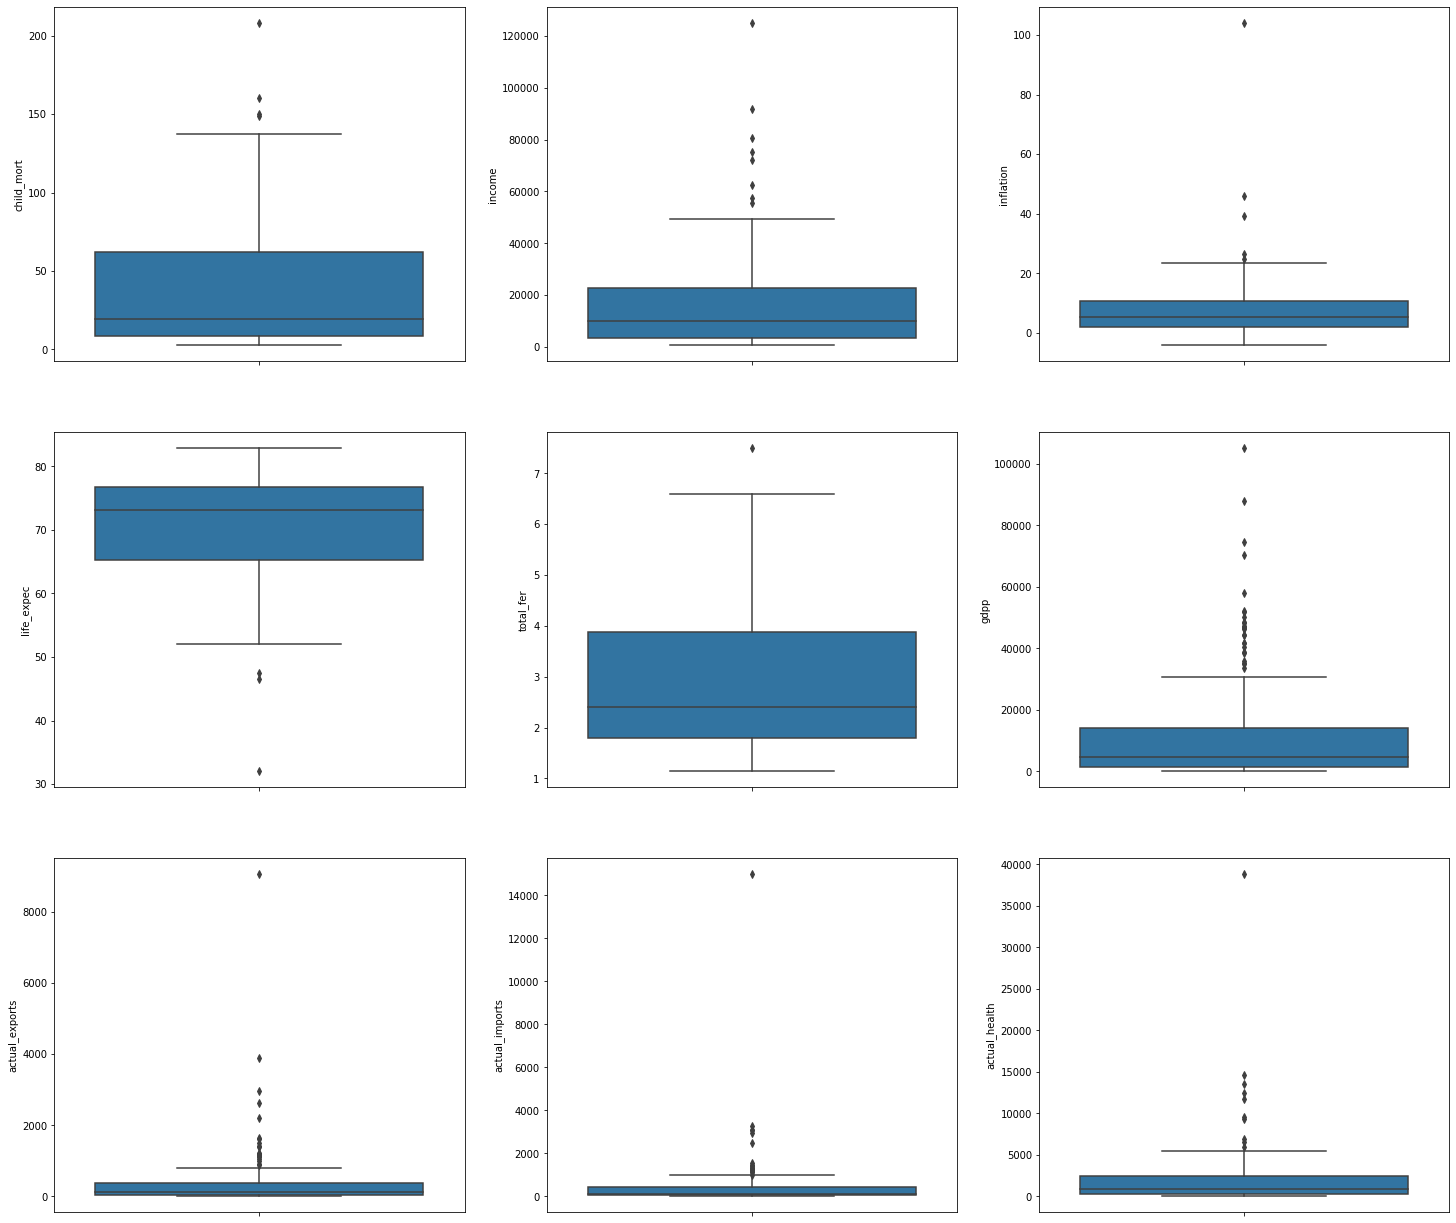

In [13]:
# Check for outliers in every column except country as it is unique

plt.figure(figsize = (25,30))
for i in enumerate(features):
    plt.subplot(4,3,i[0]+1)
    sns.boxplot(new_data[i[1]], orient="v")
    

In [14]:
for i in enumerate(features):
    
    print("99%ile of ", i[1], "is", round(new_data[i[1]].quantile(.99),2), "and 100%ile is", round(new_data[i[1]].quantile(1.0),2))
    

99%ile of  child_mort is 153.4 and 100%ile is 208.0
99%ile of  income is 84374.0 and 100%ile is 125000.0
99%ile of  inflation is 41.48 and 100%ile is 104.0
99%ile of  life_expec is 82.37 and 100%ile is 82.8
99%ile of  total_fer is 6.56 and 100%ile is 7.49
99%ile of  gdpp is 79088.0 and 100%ile is 105000.0
99%ile of  actual_exports is 3285.1 and 100%ile is 9064.22
99%ile of  actual_imports is 3145.76 and 100%ile is 14992.41
99%ile of  actual_health is 13896.11 and 100%ile is 38839.78


Looking at the above box-plots it is clear that there are outliers present which can drastically affect our clustering as clustering is distance based method.
In order to treat outliers will need to treat upper and lower outliers separately for each column focusing our problem statement.

Hence for each column will perform treatment as follow:

1. child_mort : Will not treat upper outliers as we need to identify countries whom immediate aid can be provided and high child_mort plays imp role in deciding.

2. income : Can fix upper outliers.

3. inflation : There seems to not much of inflation pointers as 99%ile is 41.48 and 100%ile is 104

4. life_expec : No upper outliers but there are few lower outliers which is important for analysis hence will not treat it.

5. total_fer : There seems to not much of difference in 99%ile (6.56) and 100%ile (7.49) hence no need to treat outliers

6. gdpp : Looking at the box-plot it looks like there are several outliers, which in real world we know as developed nations. We need to treat these outliers otherwise it will drastically affect the clustering of lower end gdpp

7. actual_exports : Need to treat upper end outliers

8. actual_imports : Need to treat upper end outliers

9. actual_health : Need to treat upper end outliers

In [15]:
#### Treating outliers
print('95%ile and 100%ile before cappling outlier\n')

for i in enumerate(features):
    print("95%ile of ", i[1], "is", round(new_data[i[1]].quantile(.95),2), "and 100%ile is", round(new_data[i[1]].quantile(1.0),2))



# We will cap the outliers in soft rang, i.e. 99%ile 

cap_col = ['income', 'gdpp','actual_exports','actual_imports','actual_health']

for i in cap_col:
    upper_limit = new_data[i].quantile(.95)
    new_data[i][new_data[i]>upper_limit] = upper_limit

print('\n95%ile and 100%ile after cappling outlier\n')

# cross-check
for i in enumerate(features):
    print("95%ile of ", i[1], "is", round(new_data[i[1]].quantile(.95),2), "and 100%ile is", round(new_data[i[1]].quantile(1.0),2))

95%ile and 100%ile before cappling outlier

95%ile of  child_mort is 116.0 and 100%ile is 208.0
95%ile of  income is 48290.0 and 100%ile is 125000.0
95%ile of  inflation is 20.87 and 100%ile is 104.0
95%ile of  life_expec is 81.4 and 100%ile is 82.8
95%ile of  total_fer is 5.86 and 100%ile is 7.49
95%ile of  gdpp is 48610.0 and 100%ile is 105000.0
95%ile of  actual_exports is 1408.27 and 100%ile is 9064.22
95%ile of  actual_imports is 1378.82 and 100%ile is 14992.41
95%ile of  actual_health is 6324.37 and 100%ile is 38839.78

95%ile and 100%ile after cappling outlier

95%ile of  child_mort is 116.0 and 100%ile is 208.0
95%ile of  income is 47513.0 and 100%ile is 48290.0
95%ile of  inflation is 20.87 and 100%ile is 104.0
95%ile of  life_expec is 81.4 and 100%ile is 82.8
95%ile of  total_fer is 5.86 and 100%ile is 7.49
95%ile of  gdpp is 48547.0 and 100%ile is 48610.0
95%ile of  actual_exports is 1399.62 and 100%ile is 1408.27
95%ile of  actual_imports is 1364.26 and 100%ile is 1378.82
9

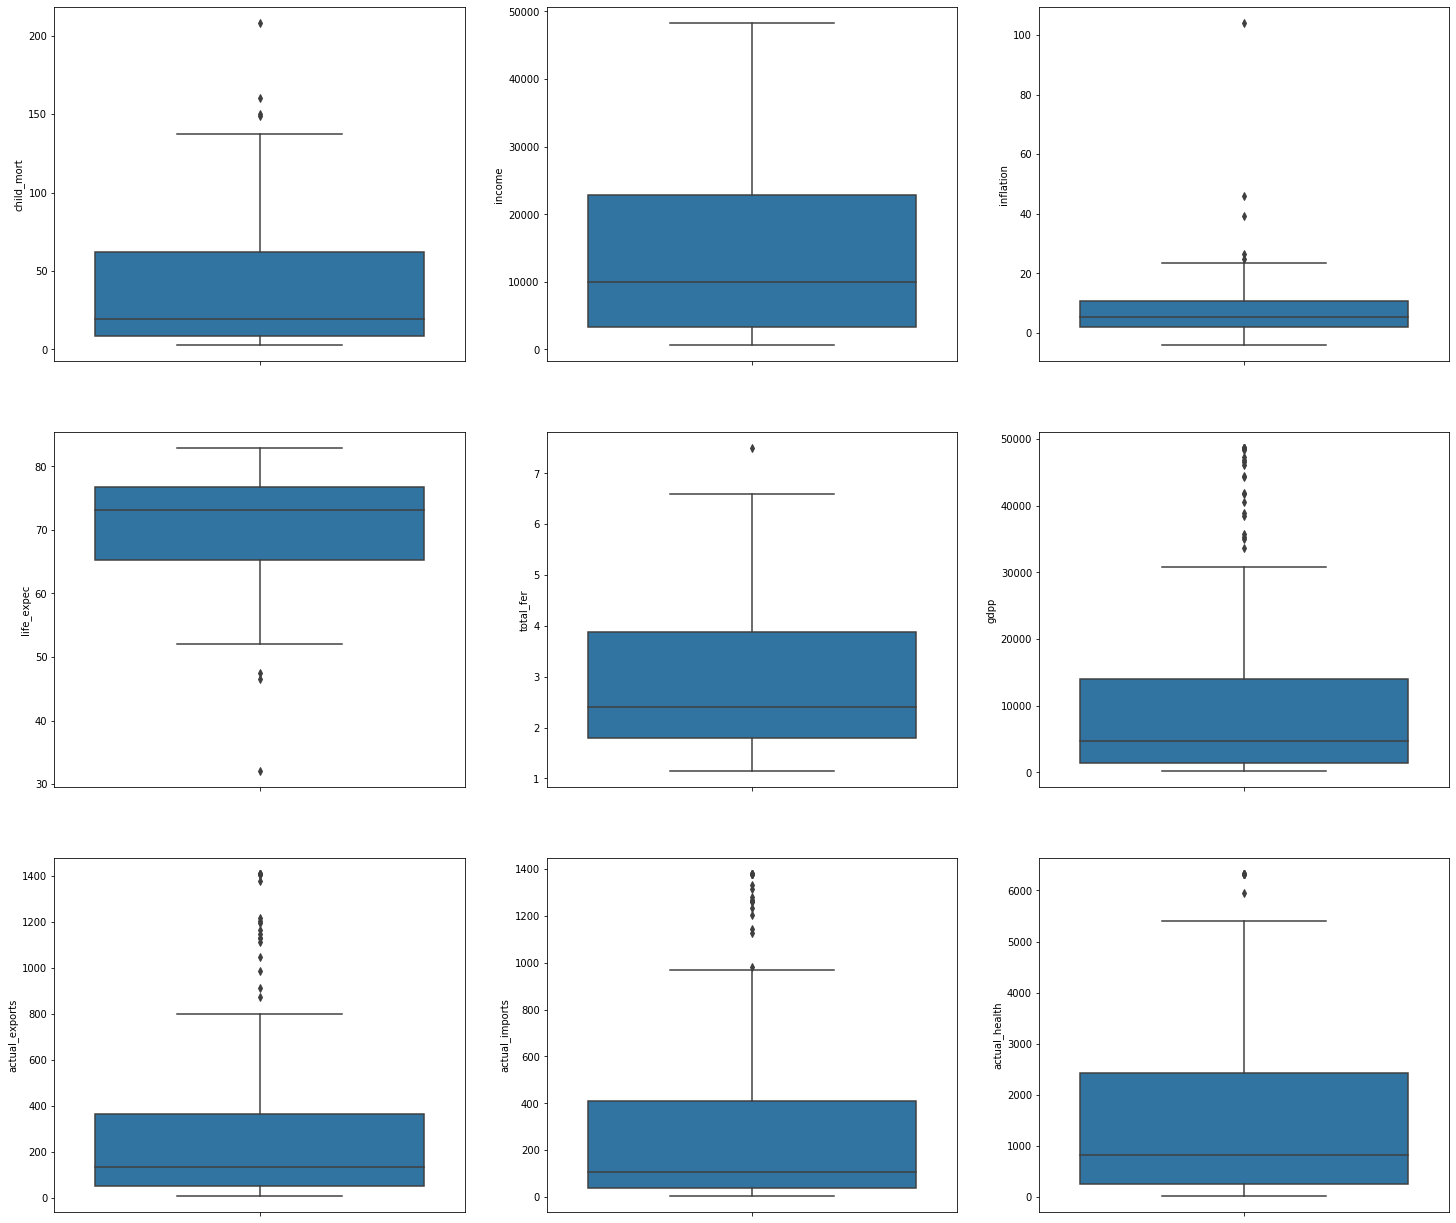

In [16]:
# Check for outliers in every column except country as it is unique

plt.figure(figsize = (25,30))
for i in enumerate(features):
    plt.subplot(4,3,i[0]+1)
    sns.boxplot(new_data[i[1]], orient="v")

##### After capping for 95% for few mandatory columns, There are not much of outliers left, hence we can proceed with it.

# 4. EDA

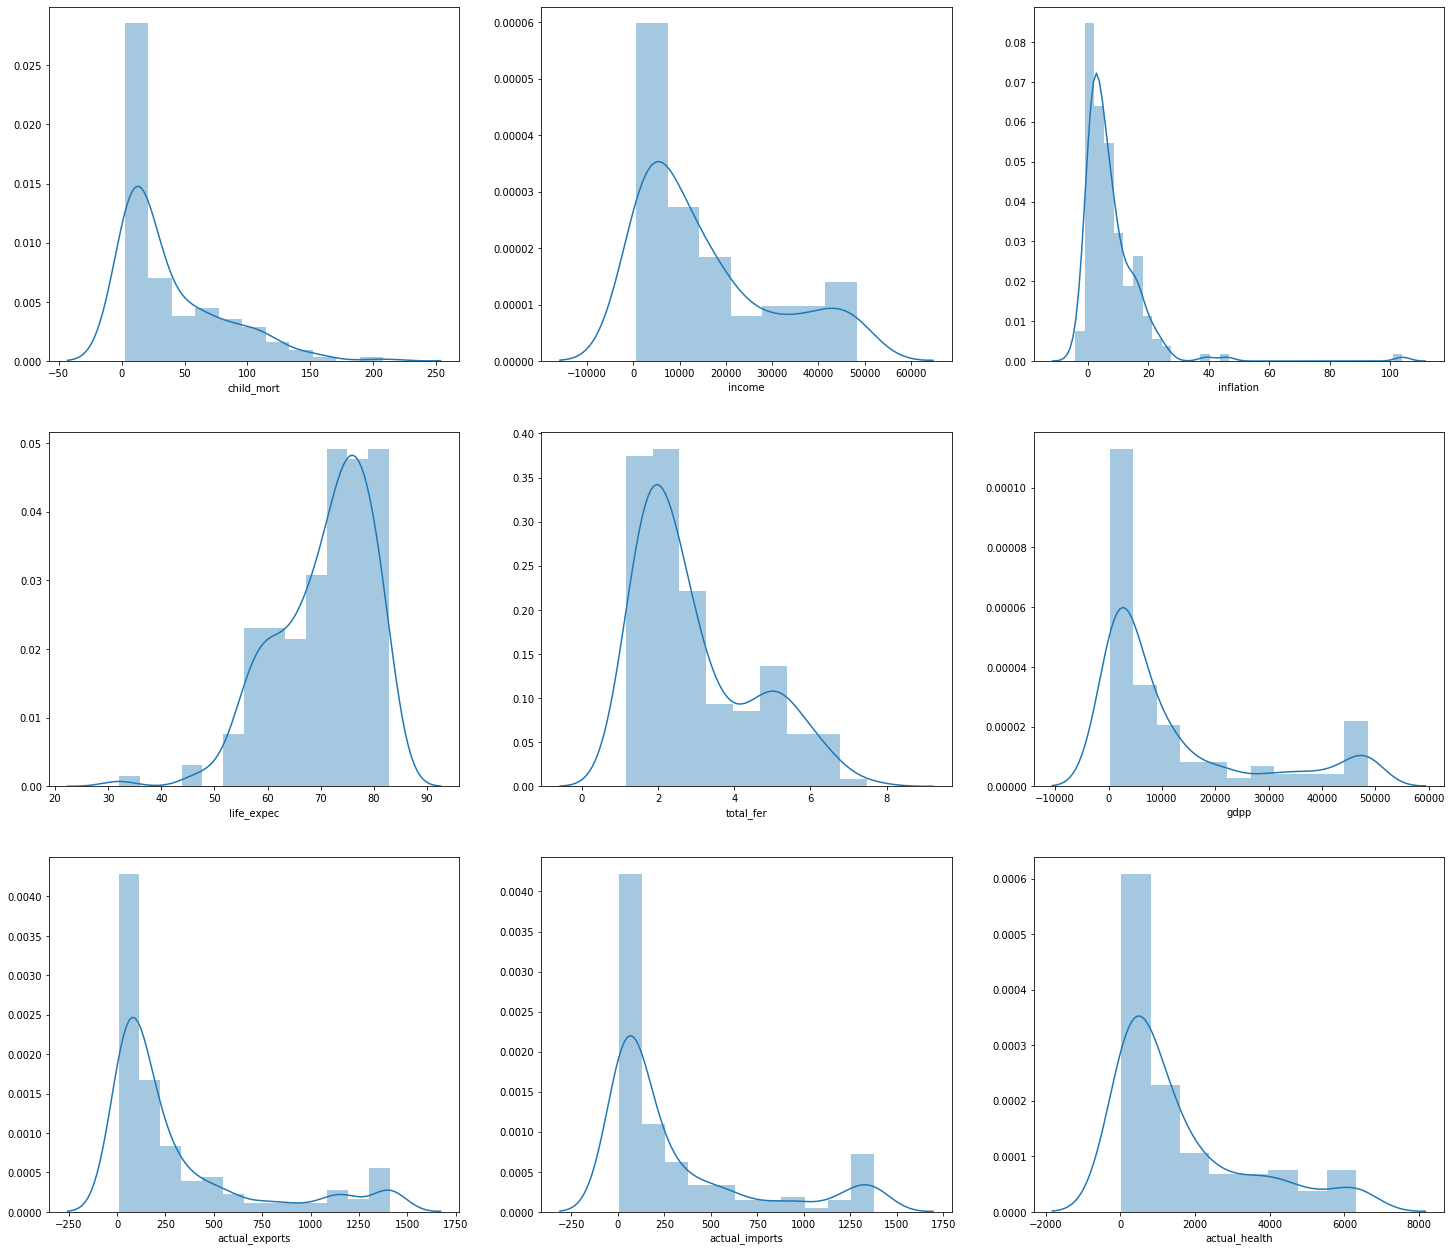

In [17]:
# Since all columns are continuous variable, we will perform EDA accordingly

#disctribution graph

plt.figure(figsize = (25,30))
for i in enumerate(features):
    plt.subplot(4,3,i[0]+1)
    sns.distplot(new_data[i[1]],)

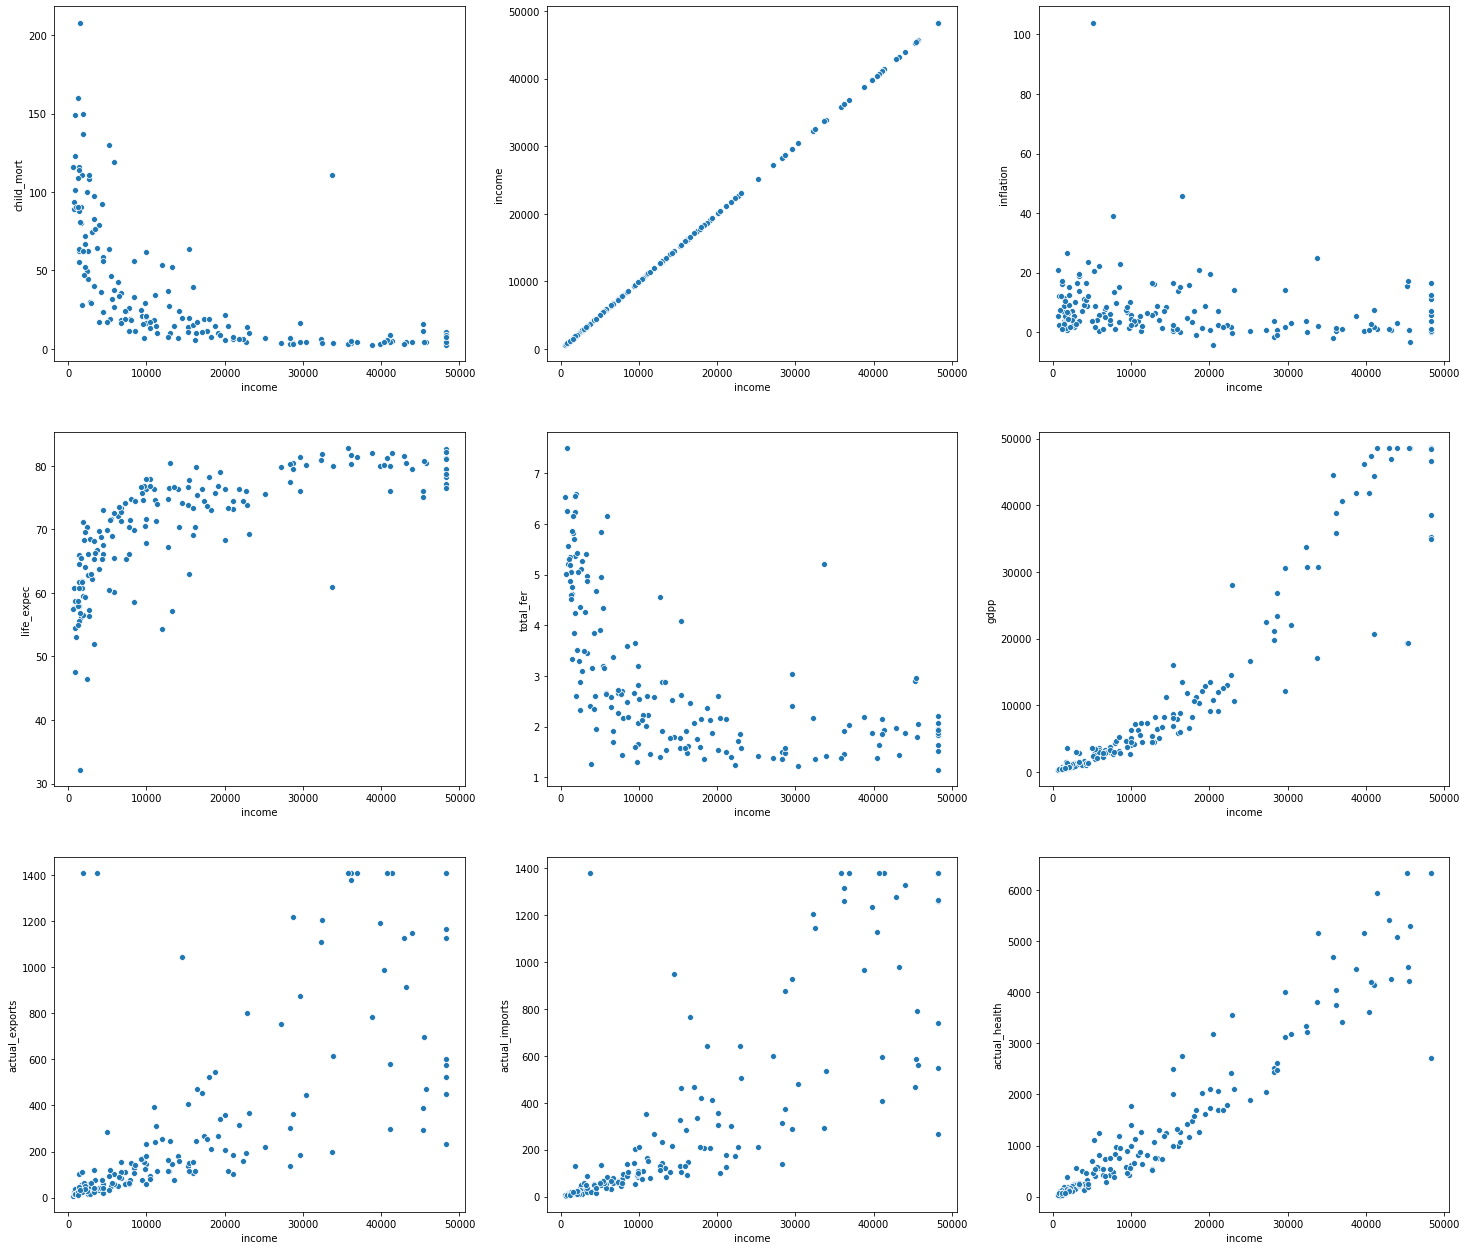

In [18]:
#bi-variate analysis with income as fixed variable

features

plt.figure(figsize = (25,30))
for i in enumerate(features):
    plt.subplot(4,3,i[0]+1)
#     sns.distplot(new_data[i[1]],)
    sns.scatterplot(x=new_data['income'],y=new_data[i[1]])

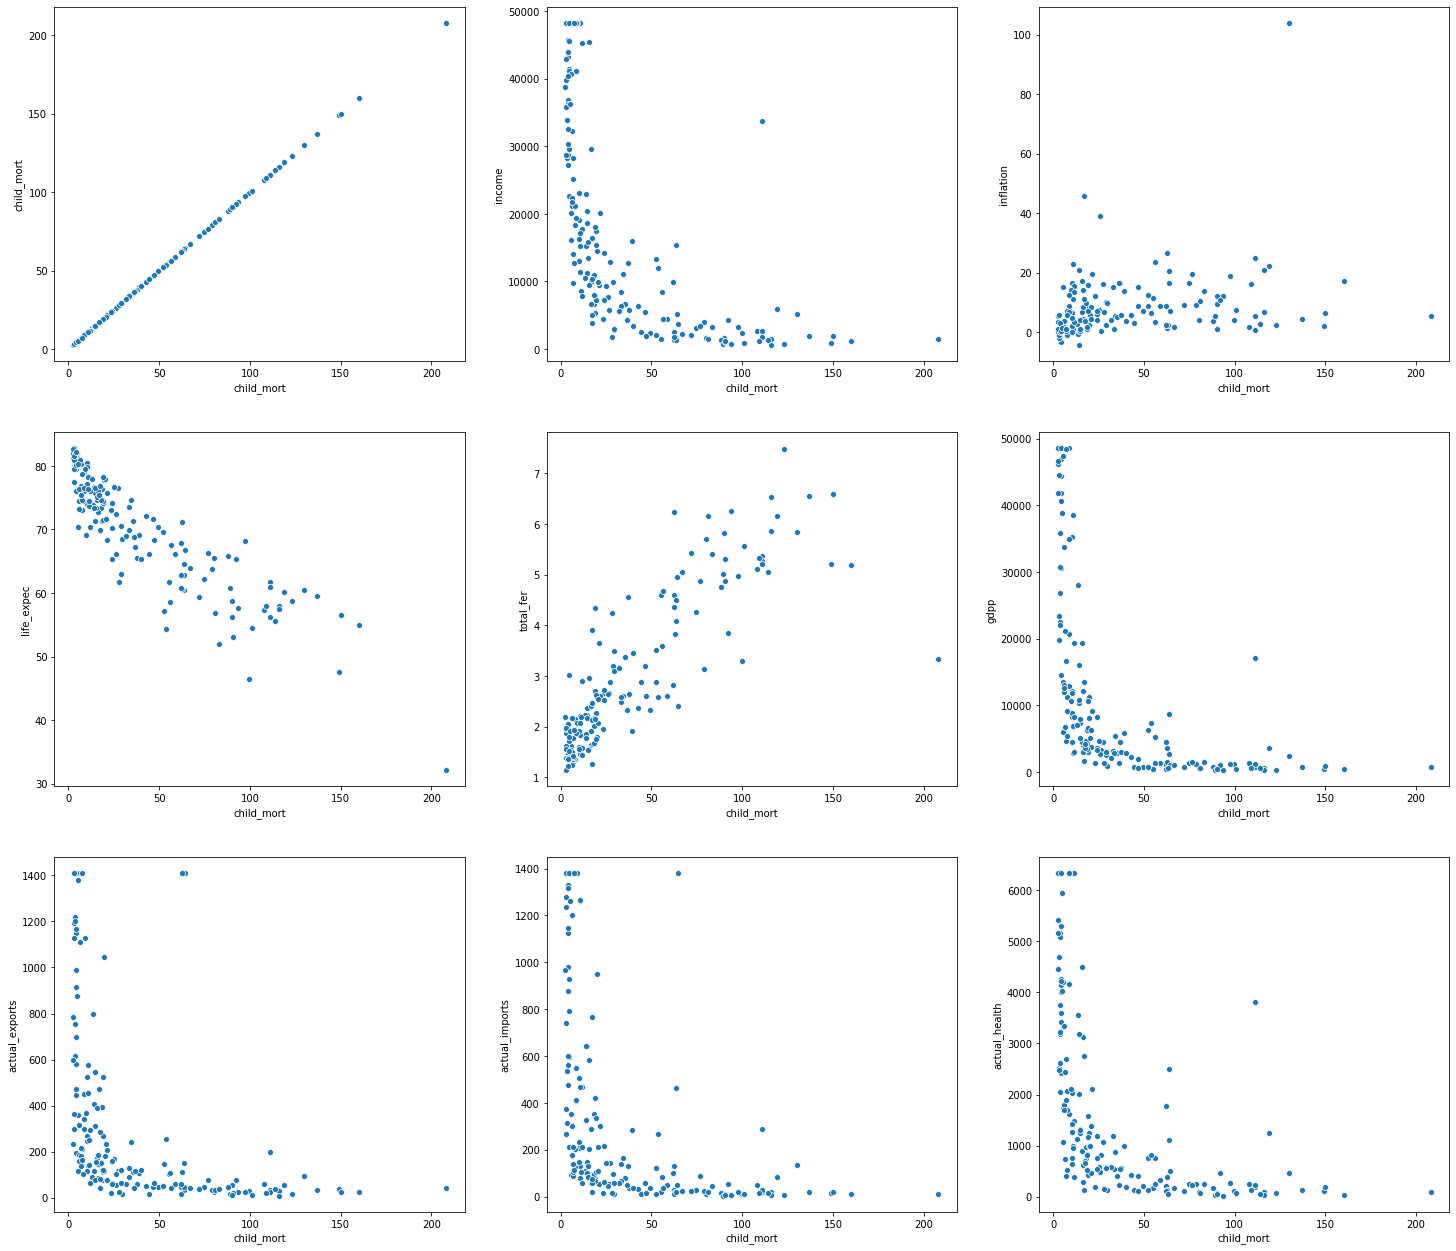

In [19]:
#bi-variate analysis with Child_mortality as fixed variable

features

plt.figure(figsize = (25,30))
for i in enumerate(features):
    plt.subplot(4,3,i[0]+1)
#     sns.distplot(new_data[i[1]],)
    sns.scatterplot(x=new_data['child_mort'],y=new_data[i[1]])

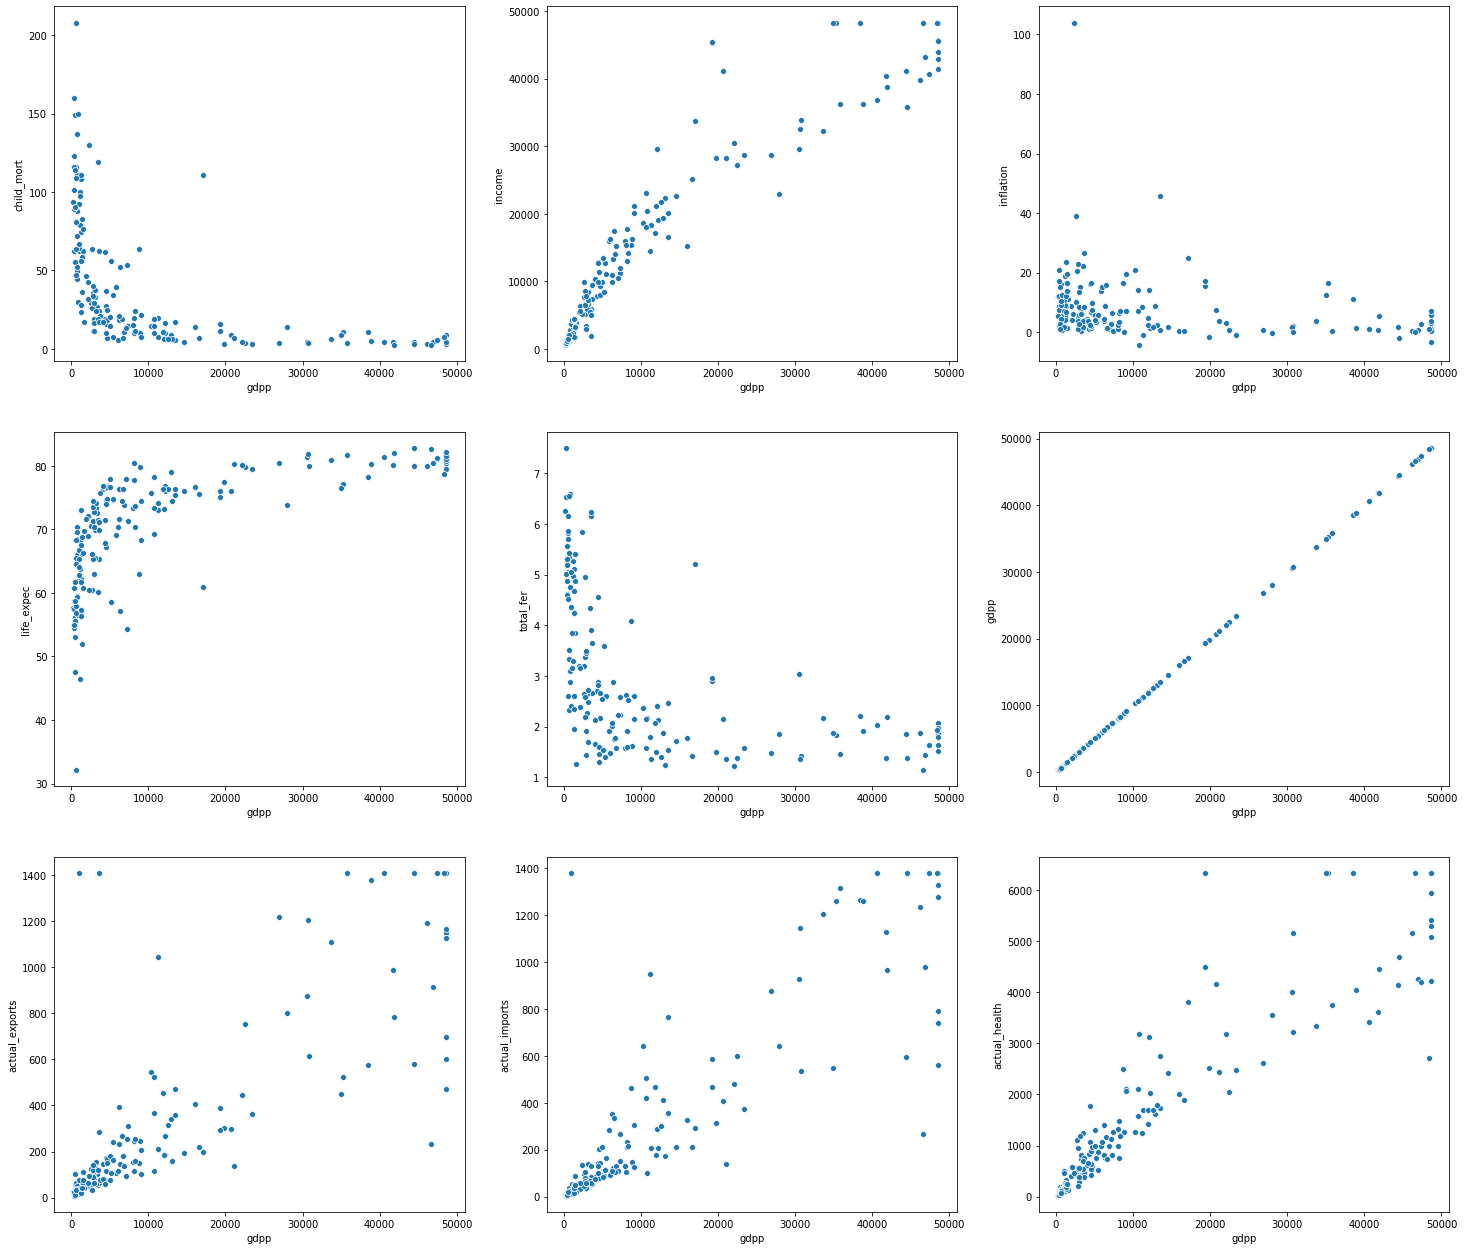

In [20]:
#bi-variate analysis with GDP as fixed variable

features

plt.figure(figsize = (25,30))
for i in enumerate(features):
    plt.subplot(4,3,i[0]+1)
#     sns.distplot(new_data[i[1]],)
    sns.scatterplot(x=new_data['gdpp'],y=new_data[i[1]])

##### Insights: 
1. Child mortality shows strong inverse relationship with income of country.
2. Life Expectancy follows direct relationship with income of country & inverse relationship with child_mort
3. Age -fertility which is (total_fer) decreases where income is high and increases with increase in child_mort or vice versa.
4. Export, import, GDP and expenditure on health show direct relationship with income of country and inverse relationship with child_mort

# 5. Preparing Data

In [21]:
new_data.describe()

,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,15738.760479,7.781832,70.555689,2.947964,11998.826347,312.180685,313.509399,1624.615006
std,40.328931,14787.154215,10.570704,8.893172,1.513848,15158.213199,401.497417,418.667569,1810.207244
min,2.600000,609.000000,-4.210000,32.100000,1.150000,231.000000,8.126521,3.531317,19.913793
25%,8.250000,3355.000000,1.810000,65.300000,1.795000,1330.000000,53.297059,36.695019,251.926804
50%,19.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,136.254980,108.562691,834.615385
75%,62.100000,22800.000000,10.750000,76.800000,3.880000,14050.000000,365.178743,409.410170,2430.266778
max,208.000000,48290.000000,104.000000,82.800000,7.490000,48610.000000,1408.274232,1378.819905,6324.374720


## 1. Hopkins Test

In [22]:
new_data.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health
0,Afghanistan,90.2,1610.0,9.44,56.2,5.82,553,55.300000,12.316258,72.955145
1,Albania,16.6,9930.0,4.49,76.3,1.65,4090,146.071429,84.156379,624.427481
2,Algeria,27.3,12900.0,16.10,76.5,2.89,4460,116.145833,142.038217,1069.544365
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491
4,Antigua and Barbuda,10.3,19100.0,1.44,76.8,2.13,12200,268.131868,207.130730,2023.217247


In [23]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
for i in range(0,10):
    print((i+1),") Hopkins score", round(hopkins(new_data.drop('country', axis=1)),2))

1 ) Hopkins score 0.93
2 ) Hopkins score 0.88
3 ) Hopkins score 0.91
4 ) Hopkins score 0.89
5 ) Hopkins score 0.83
6 ) Hopkins score 0.92
7 ) Hopkins score 0.93
8 ) Hopkins score 0.87
9 ) Hopkins score 0.8
10 ) Hopkins score 0.95


### LoOKING AT THE HOPKINS SCORE IT SEEMS THAT DATA CAN BE CLUSTERED.


## 2. Scaling the data 


In [25]:
scaler = StandardScaler()
new_data1 = scaler.fit_transform(new_data.drop('country', axis=1))

In [26]:
new_data1

array([[ 1.29153238, -0.95834891,  0.15733622, ..., -0.6417308 ,
        -0.72157246, -0.85975046],
       [-0.5389489 , -0.3940062 , -0.31234747, ..., -0.41496863,
        -0.54946411, -0.55418827],
       [-0.27283273, -0.19255214,  0.78927429, ..., -0.48972776,
        -0.41079582, -0.30755596],
       ...,
       [-0.37231541, -0.76299951,  0.40973191, ..., -0.73442667,
        -0.7119467 , -0.79405527],
       [ 0.44841668, -0.76367781,  1.50091625, ..., -0.67079281,
        -0.65984657, -0.76004819],
       [ 1.11495062, -0.84507339,  0.59001454, ..., -0.68130312,
        -0.63788316, -0.76282858]])

## 3. Check for optimum number of clusters (K)

### Silhouette Score

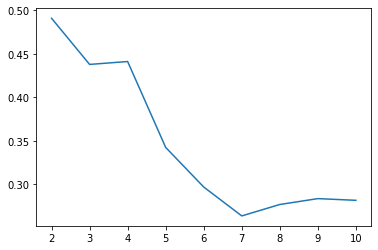

In [27]:
# Silhouette Score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


ss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(new_data1)
    ss.append([k, silhouette_score(new_data1, kmeans.labels_)])

plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])

### Elbow Curve

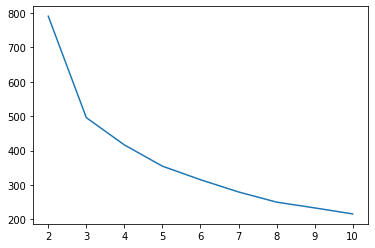

In [28]:
#Elbow curve

ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(new_data1)
    ssd.append([k, kmean.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])

### Looking at the Silhouette score and elbow curve, K=3 seems to be optimal

# 6. Clustering the data

## 6.1 Using K-Means

In [29]:
kmean = KMeans(n_clusters=3, random_state=300)
kmean.fit(new_data1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=300, tol=0.0001, verbose=0)

In [30]:
Cluster_labels = pd.DataFrame(kmean.labels_, columns=['Cluster_labels'])

In [31]:
Cluster_labels

,Cluster_labels
0,1
1,2
2,2
3,1
4,2
...,...
162,2
163,2
164,2
165,1


In [32]:
new_data.kmean = new_data.copy()

In [33]:
new_data.kmean = pd.concat([new_data.kmean, Cluster_labels], axis=1)

In [34]:
new_data.kmean.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health,Cluster_labels
0,Afghanistan,90.2,1610.0,9.44,56.2,5.82,553,55.300000,12.316258,72.955145,1
1,Albania,16.6,9930.0,4.49,76.3,1.65,4090,146.071429,84.156379,624.427481,2
2,Algeria,27.3,12900.0,16.10,76.5,2.89,4460,116.145833,142.038217,1069.544365,2
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491,1
4,Antigua and Barbuda,10.3,19100.0,1.44,76.8,2.13,12200,268.131868,207.130730,2023.217247,2


In [35]:
new_data.kmean.Cluster_labels.value_counts()

2    84
1    48
0    35
Name: Cluster_labels, dtype: int64

### Check clustered data w.r.t. child_mort, gdpp & income after revision

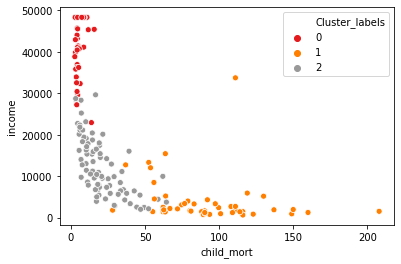

In [36]:
# 1. Clustered data of child_mort vs income

sns.scatterplot(data=new_data.kmean, x='child_mort', y='income', hue='Cluster_labels', palette='Set1')


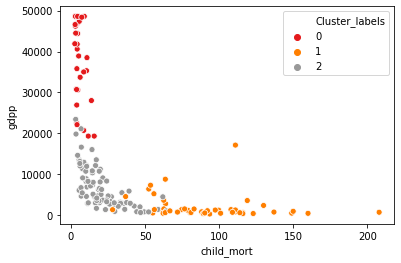

In [37]:
# 2. Clustered data of child_mort vs gdpp

sns.scatterplot(data=new_data.kmean, x='child_mort', y='gdpp', hue='Cluster_labels', palette='Set1')

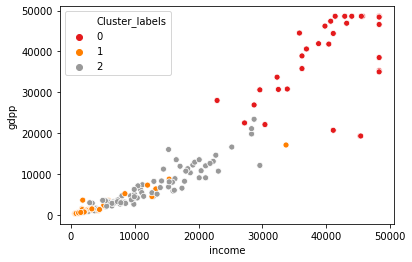

In [38]:
# 2. Clustered data of income vs gdpp

sns.scatterplot(data=new_data.kmean, x='income', y='gdpp', hue='Cluster_labels', palette='Set1')

### Cluster Profiling

In [39]:
new_data.kmean.columns

Index(['country', 'child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'actual_exports', 'actual_imports',
       'actual_health', 'Cluster_labels'],
      dtype='object')

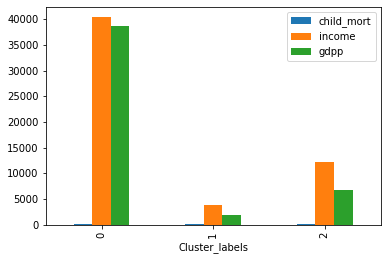

In [40]:
# Will try to priofile clustered data w.r.t to Child_mort, gdpp & income

new_data.kmean.drop(['country', 'inflation', 'life_expec',
       'total_fer', 'actual_exports', 'actual_imports',
       'actual_health'], axis=1).groupby('Cluster_labels').mean().plot(kind='bar')

### It seems to be a clear difference between 3 clusters based on income and gdpp, however for child_mortality it seems to be not clear because of scaling of income and gdpp.
#### We can either plot different graph for child_mort or can scale gdpp and income on log.


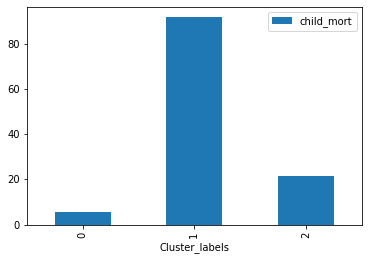

In [41]:
# plot the graph just for child_mort

new_data.kmean.drop(['country', 'inflation', 'life_expec',
       'total_fer', 'actual_exports', 'actual_imports',
       'actual_health', 'gdpp', 'income'], axis=1).groupby('Cluster_labels').mean().plot(kind='bar')

### Insights :
       1. Cluster 0: High Income, high gdpp but low child_mortality.
       2. Cluster 1: Low Income, low gdpp and high child_mortality.
       3. Cluster 2: medium income, medium gdp and medium child_mortality
      

### It is clear that we have to focus on cluster 1, from that cluster we need to find top-10 countries which are in dire need of the aid.

In [42]:
list_of_countries_data = new_data.kmean[new_data.kmean['Cluster_labels']==1].sort_values(by=['child_mort','income','gdpp'], ascending = [False,True,True]).head(10)

In [43]:
list_of_countries_data.head(10)

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health,Cluster_labels
66,Haiti,208.0,1500.0,5.45,32.1,3.33,662,43.267974,10.231839,95.803184,1
132,Sierra Leone,160.0,1220.0,17.20,55.0,5.20,399,23.750000,11.565217,30.458015,1
32,Chad,150.0,1930.0,6.39,56.5,6.59,897,24.375000,20.620690,198.013245,1
31,Central African Republic,149.0,888.0,2.01,47.5,5.21,446,37.796610,16.830189,112.060302,1
97,Mali,137.0,1870.0,4.37,59.5,6.55,708,31.052632,20.170940,142.168675,1
113,Nigeria,130.0,5150.0,104.00,60.5,5.84,2330,92.094862,133.908046,459.566075,1
112,Niger,123.0,814.0,2.55,58.8,7.49,348,15.675676,7.087576,67.441860,1
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491,1
37,"Congo, Dem. Rep.",116.0,609.0,20.80,57.5,6.54,334,8.126521,6.733871,42.225032,1
25,Burkina Faso,116.0,1430.0,6.81,57.9,5.87,575,29.947917,19.425676,85.311573,1


In [44]:
list_of_countries = list_of_countries_data['country']

In [45]:
print(list_of_countries)

66                        Haiti
132                Sierra Leone
32                         Chad
31     Central African Republic
97                         Mali
113                     Nigeria
112                       Niger
3                        Angola
37             Congo, Dem. Rep.
25                 Burkina Faso
Name: country, dtype: object


## Result using K-Means: Top 10 countries who are in dire need of aid are :
    1. Haiti
    2. Sierra Leone
    3. Chad
    4. Central African Republic
    5. Mali
    6. Nigeria
    7. Niger
    8. Angola
    9. Congo, Dem. Rep.
    10.Burkina Faso

## 6.2 Using Hierarchical clustering method

In [46]:
new_data1 = pd.DataFrame(new_data1)
new_data1.head()

,0,1,2,3,4,5,6,7,8
0,1.291532,-0.958349,0.157336,-1.619092,1.902882,-0.757362,-0.641731,-0.721572,-0.859750
1,-0.538949,-0.394006,-0.312347,0.647866,-0.859973,-0.523321,-0.414969,-0.549464,-0.554188
2,-0.272833,-0.192552,0.789274,0.670423,-0.038404,-0.498838,-0.489728,-0.410796,-0.307556
3,2.007808,-0.667360,1.387054,-1.179234,2.128151,-0.560376,-0.638330,-0.553949,-0.213887
4,-0.695634,0.227992,-0.601749,0.704258,-0.541946,0.013312,-0.110041,-0.254853,0.220859


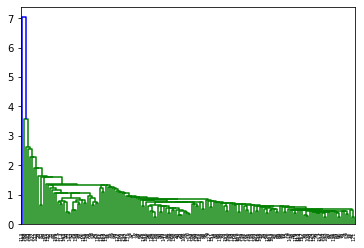

In [47]:
# single method

mergings_s = linkage(new_data1, method="single", metric='euclidean')
dendrogram(mergings_s)
plt.show()

In [48]:
# 3 clusters

h_cluster_labels_s = cut_tree(mergings_s, n_clusters=3).reshape(-1,)
h_cluster_labels_s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

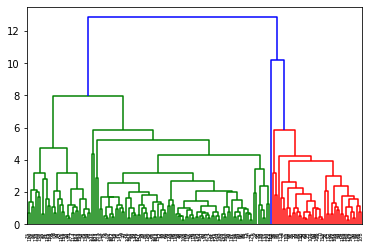

In [49]:
# complete method

mergings_c = linkage(new_data1, method="complete", metric='euclidean')
dendrogram(mergings_c)
plt.show()

In [50]:
# 3 clusters

h_cluster_labels_c = cut_tree(mergings_c, n_clusters=3).reshape(-1,)
h_cluster_labels_c

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

#### It is clearly evident that we should be using complete method.

In [51]:
# assign cluster labels

new_data['h_cluster_labels'] = h_cluster_labels_c
new_data.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health,h_cluster_labels
0,Afghanistan,90.2,1610.0,9.44,56.2,5.82,553,55.300000,12.316258,72.955145,0
1,Albania,16.6,9930.0,4.49,76.3,1.65,4090,146.071429,84.156379,624.427481,1
2,Algeria,27.3,12900.0,16.10,76.5,2.89,4460,116.145833,142.038217,1069.544365,1
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491,0
4,Antigua and Barbuda,10.3,19100.0,1.44,76.8,2.13,12200,268.131868,207.130730,2023.217247,1


### Check clustered data w.r.t. child_mort, gdpp & income

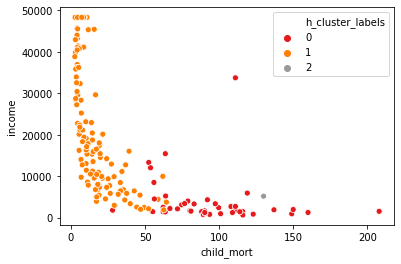

In [52]:
# 1. Clustered data of child_mort vs income

sns.scatterplot(data=new_data, x='child_mort', y='income', hue='h_cluster_labels', palette='Set1')

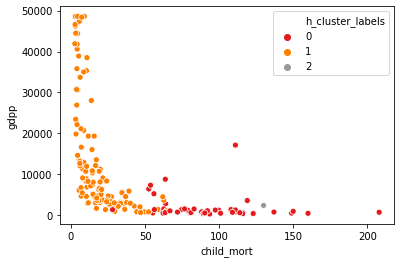

In [53]:
# 2. Clustered data of child_mort vs gdpp

sns.scatterplot(data=new_data, x='child_mort', y='gdpp', hue='h_cluster_labels', palette='Set1')

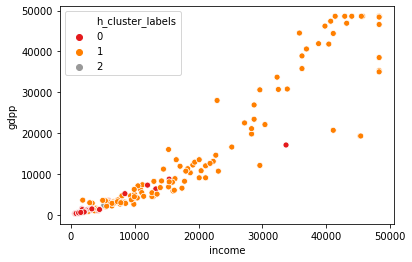

In [54]:
# 2. Clustered data of income vs gdpp

sns.scatterplot(data=new_data, x='income', y='gdpp', hue='h_cluster_labels', palette='Set1')

### 6.2.1 Cluster Profiling

In [55]:
new_data.columns

Index(['country', 'child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'actual_exports', 'actual_imports',
       'actual_health', 'h_cluster_labels'],
      dtype='object')

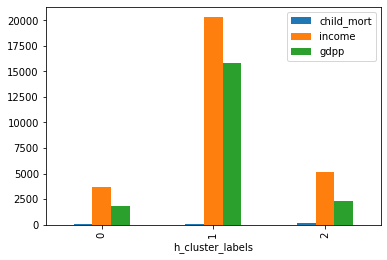

In [56]:
# Will try to priofile clustered data w.r.t to Child_mort, gdpp & income

new_data.drop(['country', 'inflation', 'life_expec',
       'total_fer', 'actual_exports', 'actual_imports',
       'actual_health'], axis=1).groupby('h_cluster_labels').mean().plot(kind='bar')

##### It seems to be a clear difference between 3 clusters based on income and gdpp, however for child_mortality it seems to be not clear because of scaling of income and gdpp.
#### We can either plot different graph for child_mort or can scale gdpp and income on log.


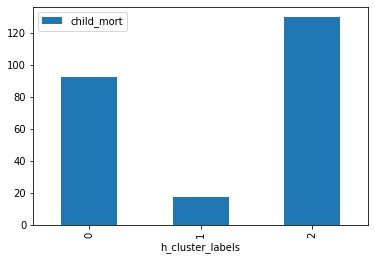

In [57]:
# plot the graph just for child_mort

new_data.drop(['country', 'inflation', 'life_expec',
       'total_fer', 'actual_exports', 'actual_imports',
       'actual_health', 'gdpp', 'income'], axis=1).groupby('h_cluster_labels').mean().plot(kind='bar')

##### There seems to not much of difference between cluster 2 and 0, hence we will revise our decision of number of clusters from 3 to 2

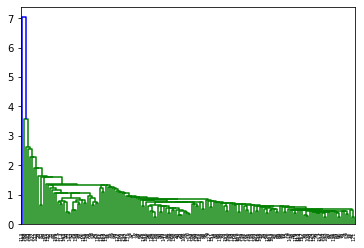

In [58]:
# single linkage

mergings_s = linkage(new_data1, method="single", metric='euclidean')
dendrogram(mergings_s)
plt.show()

In [59]:
# 2 clusters

h_cluster_labels_s = cut_tree(mergings_s, n_clusters=2).reshape(-1,)
h_cluster_labels_s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

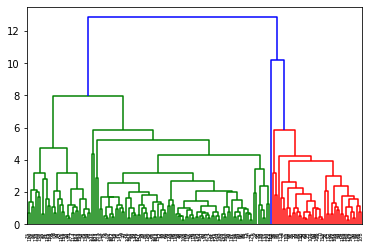

In [60]:
# complete linkage

mergings_c = linkage(new_data1, method="complete", metric='euclidean')
dendrogram(mergings_c)
plt.show()

In [61]:
# 2 clusters

h_cluster_labels_c = cut_tree(mergings_c, n_clusters=2).reshape(-1,)
h_cluster_labels_c

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

###### It is clearly evident that we should be using complete linkage.

In [62]:
# assign cluster labels

new_data['h_cluster_labels'] = h_cluster_labels_c
new_data.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health,h_cluster_labels
0,Afghanistan,90.2,1610.0,9.44,56.2,5.82,553,55.300000,12.316258,72.955145,0
1,Albania,16.6,9930.0,4.49,76.3,1.65,4090,146.071429,84.156379,624.427481,1
2,Algeria,27.3,12900.0,16.10,76.5,2.89,4460,116.145833,142.038217,1069.544365,1
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491,0
4,Antigua and Barbuda,10.3,19100.0,1.44,76.8,2.13,12200,268.131868,207.130730,2023.217247,1


### Check clustered data w.r.t. child_mort, gdpp & income after revision

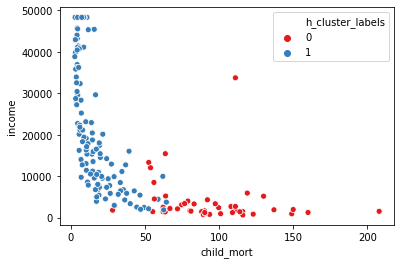

In [63]:
# 1. Clustered data of child_mort vs income

sns.scatterplot(data=new_data, x='child_mort', y='income', hue='h_cluster_labels', palette='Set1')

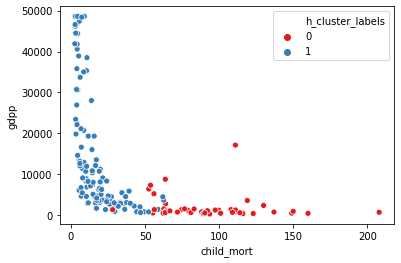

In [64]:
# 2. Clustered data of child_mort vs gdpp

sns.scatterplot(data=new_data, x='child_mort', y='gdpp', hue='h_cluster_labels', palette='Set1')

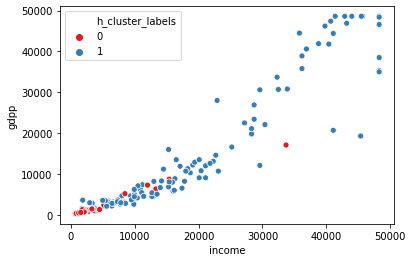

In [65]:
# 2. Clustered data of income vs gdpp

sns.scatterplot(data=new_data, x='income', y='gdpp', hue='h_cluster_labels', palette='Set1')

### Cluster Profiling after revision

In [66]:
new_data.columns

Index(['country', 'child_mort', 'income', 'inflation', 'life_expec',
       'total_fer', 'gdpp', 'actual_exports', 'actual_imports',
       'actual_health', 'h_cluster_labels'],
      dtype='object')

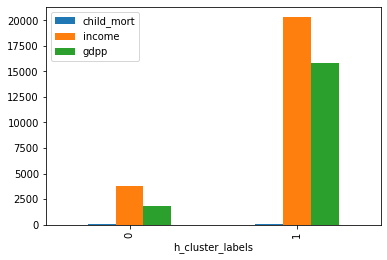

In [67]:
# Will try to priofile clustered data w.r.t to Child_mort, gdpp & income

new_data.drop(['country', 'inflation', 'life_expec',
       'total_fer', 'actual_exports', 'actual_imports',
       'actual_health'], axis=1).groupby('h_cluster_labels').mean().plot(kind='bar')

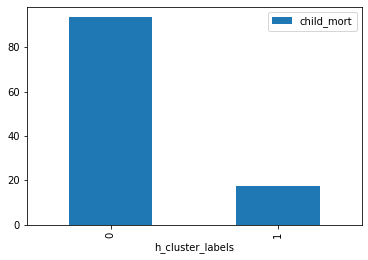

In [68]:
# plot the graph just for child_mort

new_data.drop(['country', 'inflation', 'life_expec',
       'total_fer', 'actual_exports', 'actual_imports',
       'actual_health', 'gdpp', 'income'], axis=1).groupby('h_cluster_labels').mean().plot(kind='bar')

### Insights :
       1. Cluster 0: High Income, high gdpp but low child_mortality.
       2. Cluster 1: Low Income, low gdpp and high child_mortality.
     

### It is clear that we have to focus on cluster 0, from that cluster we need to find top-10 countries which are in dire need of the aid.

In [69]:
list_of_countries_data = new_data[new_data['h_cluster_labels']==0].sort_values(by=['child_mort','income','gdpp'], ascending = [False,True,True]).head(10)

In [70]:
list_of_countries_data.head(10)

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,actual_exports,actual_imports,actual_health,h_cluster_labels
66,Haiti,208.0,1500.0,5.45,32.1,3.33,662,43.267974,10.231839,95.803184,0
132,Sierra Leone,160.0,1220.0,17.20,55.0,5.20,399,23.750000,11.565217,30.458015,0
32,Chad,150.0,1930.0,6.39,56.5,6.59,897,24.375000,20.620690,198.013245,0
31,Central African Republic,149.0,888.0,2.01,47.5,5.21,446,37.796610,16.830189,112.060302,0
97,Mali,137.0,1870.0,4.37,59.5,6.55,708,31.052632,20.170940,142.168675,0
113,Nigeria,130.0,5150.0,104.00,60.5,5.84,2330,92.094862,133.908046,459.566075,0
112,Niger,123.0,814.0,2.55,58.8,7.49,348,15.675676,7.087576,67.441860,0
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,56.661316,82.284382,1238.596491,0
37,"Congo, Dem. Rep.",116.0,609.0,20.80,57.5,6.54,334,8.126521,6.733871,42.225032,0
25,Burkina Faso,116.0,1430.0,6.81,57.9,5.87,575,29.947917,19.425676,85.311573,0


In [71]:
list_of_countries = list_of_countries_data['country']

In [72]:
print(list_of_countries)

66                        Haiti
132                Sierra Leone
32                         Chad
31     Central African Republic
97                         Mali
113                     Nigeria
112                       Niger
3                        Angola
37             Congo, Dem. Rep.
25                 Burkina Faso
Name: country, dtype: object


## Result using Hierarchical: Top 10 countries who are in dire need of aid are :
    1. Haiti
    2. Sierra Leone
    3. Chad
    4. Central African Republic
    5. Mali
    6. Nigeria
    7. Niger
    8. Angola
    9. Congo, Dem. Rep.
    10. Burkina Faso

# 7. Final Result:
# There is no difference in the end result of the countries which we want to select. Hence both method is correct, still if I would prefer, it would be K-Mean method.

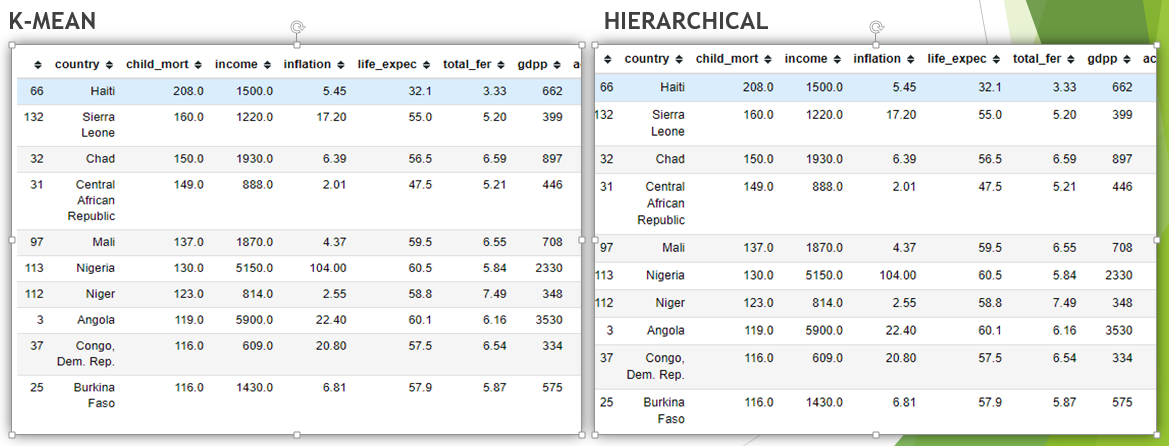